In [192]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline


# code to show how haufe-transformed feature weights are related to data covariance

In [193]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header =0)
    return df

In [313]:
df = load_csv('~/GIT/archive/data.csv')

llvars = ['M1_CST', 'PMd_CST', 'PMv_CST','S1_CST','SMA_CST','preSMA_CST']

motor = df['NORMED_MOTOR']
lesion_load = df[llvars]
print(lesion_load)

X_train, X_test, y_train, y_test = train_test_split(lesion_load, motor, test_size=0.2, random_state=42)

# normalize X (in the same way that is done in Ridge)
X_train_norm = (X_train - np.mean(X_train,axis=0))/np.std(X_train,axis=0)

mdl = Ridge(normalize=True, max_iter=1000000, random_state=0)
mdl.fit(X_train_norm, y_train)

coefs = mdl.coef_

        M1_CST   PMd_CST   PMv_CST    S1_CST   SMA_CST  preSMA_CST
0     0.002082  0.102837  0.541656  0.010315  0.028453    0.052155
1     0.000925  0.014657  0.048664  0.000000  0.014622    0.009607
2     0.004280  0.039716  0.022745  0.000175  0.051176    0.076585
3     0.306340  0.400946  0.000000  0.034965  0.413357    0.446884
4     0.226516  0.161466  0.166623  0.234091  0.139103    0.167444
...        ...       ...       ...       ...       ...         ...
1015  0.035400  0.012057  0.038350  0.018881  0.030626    0.000000
1016  0.044655  0.074941  0.050780  0.055070  0.068168    0.073017
1017  0.206617  0.142553  0.588204  0.321678  0.114207    0.103761
1018  0.000000  0.000000  0.000000  0.011713  0.000000    0.000000
1019  0.006478  0.009929  0.008067  0.007605  0.009978    0.009882

[1020 rows x 6 columns]


### Haufe transformation:

$W$ = Regression coefficients

$\sum_x$ = Input data covariance

$\sum_{\hat{s}}^{-1}$ = Response data covariance (1-D) = single value


#### Formula for transformation:

$A = \sum_xW\sum_{\hat{s}}^{-1}$


In [322]:
# haufe feature transformation

# data covariance
print('X_train shape {}'.format(X_train_norm.shape))
cov_x=np.cov(np.transpose(X_train_norm))

# predictor covariance
print('y_train shape {}'.format(y_train.shape))
cov_y=np.cov(np.transpose(y_train))

beta_coeffs = mdl.coef_

weight=beta_coeffs
print('weight shape {}'.format(weight.shape))

haufe_activation=np.matmul(cov_x,weight)/(1/cov_y)

X_train shape (816, 6)
y_train shape (816,)
weight shape (6,)


#### Features have mean 0 and unit variance:

In [324]:
print('\n Mean:')
print(np.mean(X_train_norm,axis=0))
print('\n Variance:')
print(np.var(X_train_norm,axis=0))


 Mean:
M1_CST       -6.530724e-17
PMd_CST      -4.898043e-17
PMv_CST      -8.707632e-18
S1_CST       -4.789197e-17
SMA_CST      -7.619178e-17
preSMA_CST   -2.721135e-18
dtype: float64

 Variance:
M1_CST        1.0
PMd_CST       1.0
PMv_CST       1.0
S1_CST        1.0
SMA_CST       1.0
preSMA_CST    1.0
dtype: float64


### Visually, Haufe-derived activations are driven by covariance rather than weights

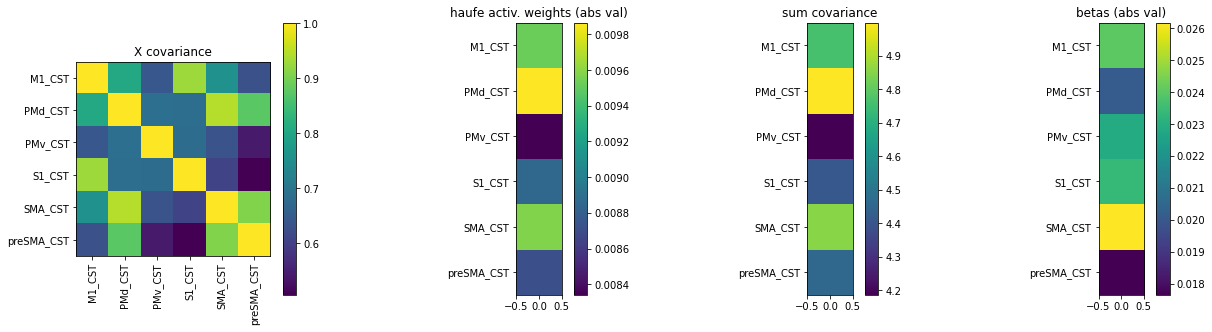

In [359]:
fig, ax = plt.subplots(1,4,figsize =(20,5))

plot = ax[0].imshow(cov_x)
ax[0].set_title('X covariance')
plt.colorbar(plot,ax=ax[0])
ax[0].set_yticks([0, 1, 2, 3,4, 5])
ax[0].set_yticklabels(llvars)
ax[0].set_xticks([0, 1, 2, 3,4, 5])
ax[0].set_xticklabels(llvars,rotation=90)

haufe = np.reshape(haufe_activation*-1, [6, 1])
plot = ax[1].imshow(haufe)
ax[1].set_title('haufe activ. weights (abs val)')
ax[1].set_yticks([0, 1, 2, 3,4, 5])
ax[1].set_yticklabels(llvars)
plt.colorbar(plot,ax=ax[1])

sum_cov = np.reshape(np.sum(cov_x,axis=0), [6, 1])
plot = ax[2].imshow(sum_cov)
ax[2].set_title('sum covariance')
ax[2].set_yticks([0, 1, 2, 3,4, 5])
ax[2].set_yticklabels(llvars)
plt.colorbar(plot,ax=ax[2])


betas = np.reshape(mdl.coef_*-1, [6, 1])
plot = ax[3].imshow(betas)
ax[3].set_title('betas (abs val)')
ax[3].set_yticks([0, 1, 2, 3,4, 5])
ax[3].set_yticklabels(llvars)
plt.colorbar(plot,ax=ax[3])


Each feature's Haufe activation is derived by :

$A_1 = C_{1, 1}w_1 + C_{1, 2}w_2 +  C_{1, 3}w_3  + ... +  C_{1, 6}w_6$

If magnitude of $C_{x, y} >> w_x$, then $A_1 = \sum_xC_{1, x}$

[[1.         0.98906519]
 [0.98906519 1.        ]]


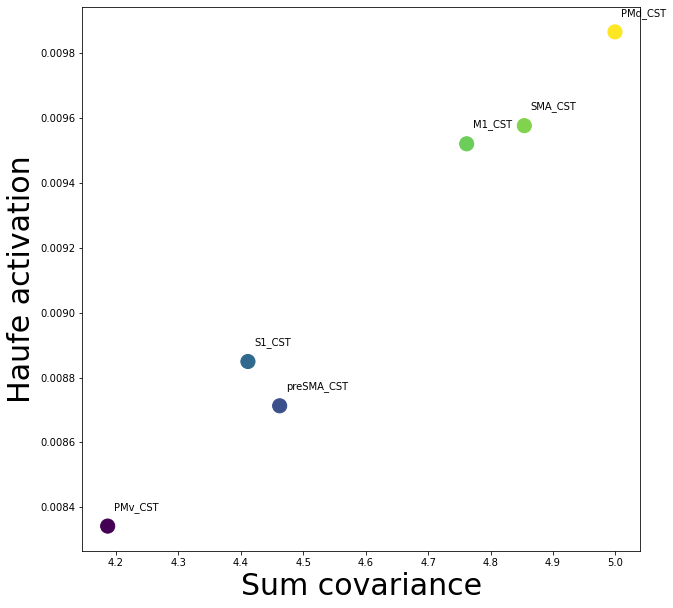

In [371]:
print(np.corrcoef(np.transpose(sum_cov), np.transpose(haufe)))

plt.subplots(figsize=(10,10))
plt.scatter(sum_cov, haufe, s=200, c= haufe)
plt.xlabel('Sum covariance',fontsize=30)
plt.ylabel('Haufe activation',fontsize=30)

for i, txt in enumerate(llvars):
    plt.annotate(txt, (sum_cov[i]+0.01, haufe[i]+0.00005))

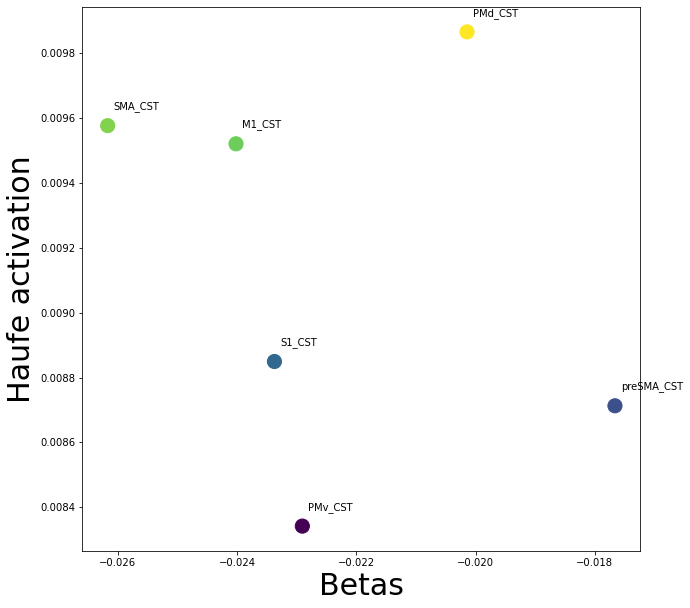

In [370]:


plt.subplots(figsize=(10,10))
plt.scatter(weight, haufe, s=200, c= haufe)
plt.xlabel('Betas',fontsize=30)
plt.ylabel('Haufe activation',fontsize=30)

for i, txt in enumerate(llvars):
    plt.annotate(txt, (weight[i]+0.0001, haufe[i]+0.00005))

### Simulation:  one variable related to the outcome and another with higher covariance and see which one shows up in the haufe weights


In [305]:
x_1 = np.random.randn(100)
x_2 = np.random.randn(100)*5

x_train = np.array([x_1, x_2])

x_train_n = (x_train - np.mean(x_train,axis=0))/np.std(x_train,axis=0)

print(np.cov(x_1))
print(np.cov(x_2))

0.9304864986312962
25.571204916854708


In [306]:
np.std(x_train_n[0])

0.9871170143402455

In [307]:
np.std(x_train_n[1])

0.9871170143402455

In [ ]:
#compute Haufe-inverted feature weights
cov_x = np.cov(np.transpose(x_train_HCP))
cov_y = np.cov(y_train_HCP)
featimp_haufe_HCP[p,:,cog] = np.matmul(cov_x,featimp_HCP[p,:,cog])*(1/cov_y)